### Import libraries

In [1]:
from datetime import datetime
import keras
from keras import backend as K
from keras.layers import Concatenate, Lambda, LSTM, Reshape, Dense, Embedding, Average, Reshape, Flatten, Input
from keras.models import Model 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import zipfile

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from typing import List, Callable, Dict
from nltk.stem import WordNetLemmatizer

### Download dataset
Downloading the dataset using the function provided in the assignment

In [2]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

# Uncomment if you need to dowload the dataset
#download_data('dataset')

### Preprocessing data

The next cells are devoted to perform preprocessing of the raw data into a readable format. This is done in two steps. The first step organises the data from the csv file into usable columns. More in particular, the Evidence column is cleaned and the Labels are turned into numeric values by the `firstCleaning(df)` function. In the second step, more specific cleaning is done on the Evidence and Claim column. All words are put in lowercase, special characters are replaced, uncommon symbols are filtered out, stopwords are removed and the text is stripped. Finally, lemmatization has been executed. 

#### Create dataframes

In [3]:
def firstCleaning(df): 
    """
    This method is to restructure the columns from dataframe df into a suitable format.  
    """
    df["Evidence"] = df["Evidence"].str.split(pat = "\t")
    df["evidenceID"]=df["Evidence"].str[0]
    df["Evidence"]=df["Evidence"].str[1]
    df["Label"] = df["Label"].replace({'SUPPORTS': 1, 'REFUTES': 0})
    return df

In [4]:
#create a dataframe for the training data 
train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
train_df = firstCleaning(train_df)

#create a dataframe for the validation data 
val_df = pd.read_csv('./dataset/val_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
val_df = firstCleaning(val_df)

#create a dataframe for the test data 
test_df = pd.read_csv('./dataset/test_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
test_df = firstCleaning(test_df)

#### Clean text data

In [5]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()    

def lemmatize_words(text: str ) -> str:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          lemmatize_words
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)


# Replace each sentence with its pre-processed version
train_df['Evidence'] = train_df['Evidence'].apply(lambda txt: text_prepare(txt))
val_df['Evidence'] = val_df['Evidence'].apply(lambda txt: text_prepare(txt))
test_df['Evidence'] = test_df['Evidence'].apply(lambda txt: text_prepare(txt))
train_df['Claim'] = train_df['Claim'].apply(lambda txt: text_prepare(txt))
val_df['Claim'] = val_df['Claim'].apply(lambda txt: text_prepare(txt))
test_df['Claim'] = test_df['Claim'].apply(lambda txt: text_prepare(txt))



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/solveig.mohr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Extract y values for train, val and test

In [6]:
y_train = np.array(train_df['Label'])
y_val = np.array(val_df['Label'])
y_test = np.array(test_df['Label'])

### Tokenize and padding of data

In [7]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["Claim"])
tokenizer.fit_on_texts(train_df["Evidence"])

In [8]:
# Find max sentence lenght for evidence
MAX_SEQ_LEN = np.max([len(text.split()) for text in train_df["Evidence"]])

In [9]:
def textToTensor(tokenizer, max_len, text):
    '''
        Converts text to tensors by converting the words into the correct indexes. 
        Then padds the tensors with 0 vlaues
    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len)
    return padded

In [10]:
claim_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Claim"])
evidence_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Evidence"])

claim_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Claim"])
evidence_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Evidence"])

claim_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Claim"])
evidence_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Evidence"])

In [11]:
# Find size of vocabulary
VOCABULARY_SIZE = len(tokenizer.word_index) + 1

## Applying glove 


In [12]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model
    
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix



In [13]:
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_dimension)
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)
embedding_matrix.shape

(32234, 50)

### Create model

- Choose type of sentence embedding by passing the sentence embedding number (1,2,3 or 4) to the create_model function.
- Choose type of merging by passing the merge number (1,2 or 3) to the create_model function.

In [14]:
def create_model(max_tokens, vocab_size, embedding_dimension, sentence_embedding_type=1, merge_type=1):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimension of the embedding vectors
            sentence_embedding_type (int): Defines which sentence embedding to use
            merge_type (int): Defines which merging function to use
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    claims_input = Input(shape=(max_tokens, ))
    evidence_input = Input(shape=(max_tokens, ))
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Word embedding ------------------------------------------------------------
    claims_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_claims', trainable = False)(claims_input)
    evidence_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_evidence', trainable = False)(evidence_input)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Sentence embedding -------------------------------------------------------
    if sentence_embedding_type==1:
        # Encode token sequences via a RNN and take the last state as the sentence embedding.
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_evidence')(evidence_embedding)
    elif sentence_embedding_type==2:
        # Encode token sequences via a RNN and average all the output states.

        # Put return_sequences True to get output from all hidden states
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence')(evidence_embedding)
        
        # Take average of outputs
        claims_sentence_embedding = K.mean(claims_sentence_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_sentence_embedding, axis=1)

    elif sentence_embedding_type==3:
        # Encode token sequences via a simple MLP layer.
        num = embedding_dimension*max_tokens
        # Reshape 3d vector to 2d
        claims_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(claims_embedding)
        evidence_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(evidence_embedding)

        # Send into dense layer
        claims_sentence_embedding = Dense(num, name='SentenceEmbedding_claims')(claims_sentence_embedding)
        evidence_sentence_embedding = Dense(num, name='SentenceEmbedding_evidence')(evidence_sentence_embedding)
   
    elif sentence_embedding_type==4:
        # Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
        claims_sentence_embedding = K.mean(claims_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_embedding, axis=1)
    else:
        raise Exception("Sentence embedding type must be an integer between 1 and 4")
    #------------------------------------------------------------------------------------------------------------
    

    #-------------------------- Extension with cosine similarity -----------------------------------------------
    # Calulate cosine similarity
    # Returns list of cosine similarities for each evidence claim pair
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
    cosine_similarity = cosine_loss(claims_sentence_embedding, evidence_sentence_embedding)

    # Expand dimention to get tensor on shape (embedding_dimension, 1)
    cosine_similarity = Lambda(lambda x: K.expand_dims(x, axis=1))(cosine_similarity)

    # Concatenate tensors and get them on shape (batch_size, embedding_dim + 1)
    claims_sentence_embedding = Concatenate(axis=-1)([claims_sentence_embedding, cosine_similarity])
    evidence_sentence_embedding = Concatenate(axis=-1)([evidence_sentence_embedding, cosine_similarity])
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Merging --------------------------------------------------------------
    if merge_type == 1:
        # Concatenate
        merged = Concatenate(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 2:
        # Sum
        merged = Add([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 3:
        # Mean
        merged = Average(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    else:
        raise Exception("Merge type must be an integer between 1 and 3")
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Classification --------------------------------------------------------------
    out = (Dense(1, activation='sigmoid'))(merged)
    #------------------------------------------------------------------------------------------------------------

    model = Model(inputs=[claims_input, evidence_input], outputs=[out])

    return model

In [15]:
# Change vaiables in order to change sentence_embedding_type and merge_type
sentence_embedding_type = 1
merge_type = 1

In [55]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_3[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_4[0][0]']          

### Train model

In [56]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=32, epochs=10, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
3805/3805 [==============================] - 201s 52ms/step - loss: 0.1735 - acc: 0.7611 - val_loss: 0.2626 - val_acc: 0.5852
Epoch 2/10
3805/3805 [==============================] - 171s 45ms/step - loss: 0.1555 - acc: 0.7879 - val_loss: 0.2499 - val_acc: 0.6173
Epoch 3/10
3805/3805 [==============================] - 180s 47ms/step - loss: 0.1456 - acc: 0.8032 - val_loss: 0.2404 - val_acc: 0.6367
Epoch 4/10
3805/3805 [==============================] - 169s 44ms/step - loss: 0.1381 - acc: 0.8141 - val_loss: 0.2410 - val_acc: 0.6430
Epoch 5/10
3805/3805 [==============================] - 183s 48ms/step - loss: 0.1318 - acc: 0.8227 - val_loss: 0.2211 - val_acc: 0.6681
Epoch 6/10
3805/3805 [==============================] - 176s 46ms/step - loss: 0.1262 - acc: 0.8310 - val_loss: 0.2281 - val_acc: 0.6632
Epoch 7/10
3805/3805 [==============================] - 212s 56ms/step - loss: 0.1215 - acc: 0.8381 - val_loss: 0.2374 - val_acc: 0.6578
Epoch 8/10
3805/3805 [===================

In [16]:
model64 = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model64.summary()

2021-12-01 21:40:14.982360: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_1[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_2[0][0]']            

In [17]:
model64.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model64.fit(x=[claim_train, evidence_train], y=y_train, batch_size=64, epochs=10, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
1903/1903 [==============================] - 137s 70ms/step - loss: 0.1764 - acc: 0.7553 - val_loss: 0.2755 - val_acc: 0.5724
Epoch 2/10
1903/1903 [==============================] - 143s 75ms/step - loss: 0.1585 - acc: 0.7834 - val_loss: 0.2479 - val_acc: 0.6089
Epoch 3/10
1903/1903 [==============================] - 134s 70ms/step - loss: 0.1488 - acc: 0.7973 - val_loss: 0.2389 - val_acc: 0.6357
Epoch 4/10
1903/1903 [==============================] - 140s 73ms/step - loss: 0.1414 - acc: 0.8080 - val_loss: 0.2358 - val_acc: 0.6500
Epoch 5/10
1903/1903 [==============================] - 124s 65ms/step - loss: 0.1352 - acc: 0.8175 - val_loss: 0.2377 - val_acc: 0.6544
Epoch 6/10
1903/1903 [==============================] - 120s 63ms/step - loss: 0.1300 - acc: 0.8256 - val_loss: 0.2321 - val_acc: 0.6606
Epoch 7/10
1903/1903 [==============================] - 148s 77ms/step - loss: 0.1253 - acc: 0.8325 - val_loss: 0.2363 - val_acc: 0.6648
Epoch 8/10
1903/1903 [===================

In [22]:
model256 = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, embedding_dimension, sentence_embedding_type=sentence_embedding_type, merge_type=merge_type)
model256.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 96, 50)      1611700     ['input_7[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 96, 50)      1611700     ['input_8[0][0]']          

In [23]:
model256.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model256.fit(x=[claim_train, evidence_train], y=y_train, batch_size=128, epochs=10, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
952/952 [==============================] - 97s 98ms/step - loss: 0.1796 - acc: 0.7495 - val_loss: 0.2582 - val_acc: 0.5722
Epoch 2/10
952/952 [==============================] - 86s 91ms/step - loss: 0.1629 - acc: 0.7760 - val_loss: 0.2488 - val_acc: 0.6078
Epoch 3/10
952/952 [==============================] - 87s 91ms/step - loss: 0.1534 - acc: 0.7914 - val_loss: 0.2354 - val_acc: 0.6311
Epoch 4/10
952/952 [==============================] - 90s 94ms/step - loss: 0.1465 - acc: 0.8007 - val_loss: 0.2372 - val_acc: 0.6363
Epoch 5/10
952/952 [==============================] - 86s 90ms/step - loss: 0.1408 - acc: 0.8101 - val_loss: 0.2354 - val_acc: 0.6396
Epoch 6/10
952/952 [==============================] - 88s 92ms/step - loss: 0.1356 - acc: 0.8176 - val_loss: 0.2382 - val_acc: 0.6441
Epoch 7/10
952/952 [==============================] - 87s 91ms/step - loss: 0.1311 - acc: 0.8239 - val_loss: 0.2354 - val_acc: 0.6574
Epoch 8/10
952/952 [==============================] - 90s 95ms

### Save model

In [24]:
def save_model(model, sentence_embedding_type=1, merge_type=1, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_SE{sentence_embedding_type}_MT{merge_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)


In [25]:
save_model(model256, sentence_embedding_type, merge_type)

2021-12-02 09:22:11.314816: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_SE1_MT1_02_12_2021_09:22:05/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT1_02_12_2021_09:22:05/assets


### Prediction
Calcualte the predictions for the test set

In [21]:
def prediction(model: keras.Model, x, predicting_info):
    '''Call the models prediction function'''
    predictions = model.predict(x, **predicting_info)
    return predictions

In [22]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

## Evaluation

### Multi-input classification evaluation

#### Defining plotting functions

In [32]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

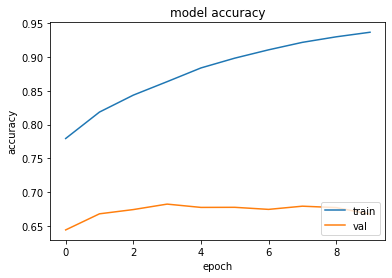

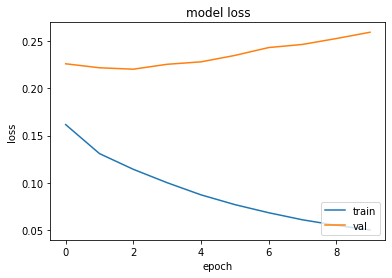

In [33]:
plot_accuracy(history)
plot_loss(history)

In [34]:
def evaluation(predictions):
    '''
        Function for plotting the confusion_matrix
        Inputs:
            predicitons: Predicitons from a keras model
    '''
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cf_matrix)

              precision    recall  f1-score   support

           0       0.72      0.51      0.60      3583
           1       0.62      0.80      0.70      3606

    accuracy                           0.66      7189
   macro avg       0.67      0.66      0.65      7189
weighted avg       0.67      0.66      0.65      7189

0.6579496452914174


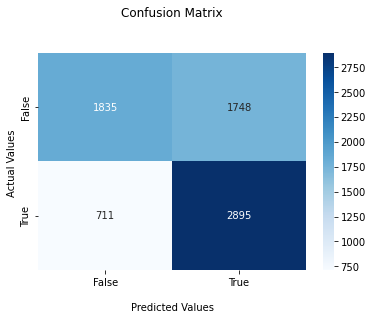

In [35]:
evaluation(predictions)

### Claim verification evaluation

In [36]:
def make_claims_dict():
    """
    Makes a dictionary with claimID as key and 
    a list of the index for every evidence 
    corresponding to the claim as value
    """
    claims = {}
    t = test_df.groupby("claimID")
    for name, group in t:
        claims[name] = list(group.index)
    return claims

In [37]:
claims_dict = make_claims_dict()

In [38]:
def majority_pred(predictions):
    """
    Find predictions based on majority voting
    """
    majority = []

    for i in range(len(claim_test)):
        claim_id = np.array(test_df['claimID'])[i]
        support = 0
        defutes = 0
        for evidence in claims_dict[claim_id]:
            if predictions[evidence] == 1:
                support += 1
            else:
                defutes += 1
        if support > defutes:
            majority.append(1.0)
        else:
            majority.append(0.0)
    return majority

In [39]:
majority_predictions = majority_pred(predictions)

              precision    recall  f1-score   support

           0       0.72      0.52      0.60      3583
           1       0.63      0.79      0.70      3606

    accuracy                           0.66      7189
   macro avg       0.67      0.66      0.65      7189
weighted avg       0.67      0.66      0.65      7189

0.6582278481012658


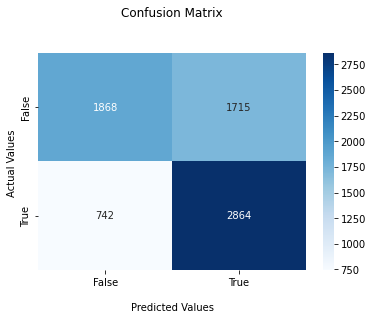

In [40]:
evaluation(majority_predictions)